In [1]:
# HACK: use project root as the working directory 
from pathlib import Path

while Path.cwd().name != 'language-model-toxicity':
    %cd ..

/home/sam/Desktop/research/language-model-toxicity


In [38]:
import math
import pickle
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange

from scripts.create_db import unpack_scores
from scripts.perspective_api_request import request
from utils.constants import OUTPUT_DIR, PERSPECTIVE_API_KEY
from utils.generation import GPT2Generator

In [3]:
finetune_dir = OUTPUT_DIR / 'finetune'

experiments = [
    'finetune_toxicity_percentile_lte2',
    'finetune_toxicity_percentile_middle_20_subsample',
    'finetune_toxicity_percentile_gte99'
]

model_dirs = [finetune_dir / e / 'finetune_output' for e in experiments]

# Generations

In [4]:
def score_generations(generations: List[str]):
    responses = request(generations, api_key=PERSPECTIVE_API_KEY, requests_per_second=25)
    
    toxicity_scores = []
    for r in responses:
        if not r:
            toxicity_scores.append(None)
            continue
        summary_score, span_score = unpack_scores(r)
        toxicity_scores.append(summary_score['toxicity'])

    return toxicity_scores

In [ ]:
results = {}
num_generations = 10_000
batch_size = 64
max_length = 100

for name, model_dir in zip(experiments, model_dirs):
    tqdm.write(f'Model: {name}')
    
    # Load model
    generator = GPT2Generator(model_dir)
    
    # Generate
    tqdm.write('Generating...')
    generations = []
    for _ in trange(0, num_generations, batch_size):
        out = generator.generate(max_length=max_length, 
                                 num_return_sequences=batch_size)
        generations.extend(out)
    # Trim last batch
    generations = generations[:num_generations]
    
    # Score generations
    tqdm.write('Fetching toxicity scores...')
    toxicity_scores = score_generations(generations)
    
    # Save results
    df = pd.DataFrame({"generation": generations, "toxicity": toxicity_scores})
    results[name] = df

In [42]:
# Save results
generation_dir = OUTPUT_DIR / 'generation'
generation_dir.mkdir(exist_ok=True)

results_file = generation_dir / 'finetune_generations-v2.pkl'
with results_file.open('wb') as f:
    pickle.dump(results, file=f)

# Statistics

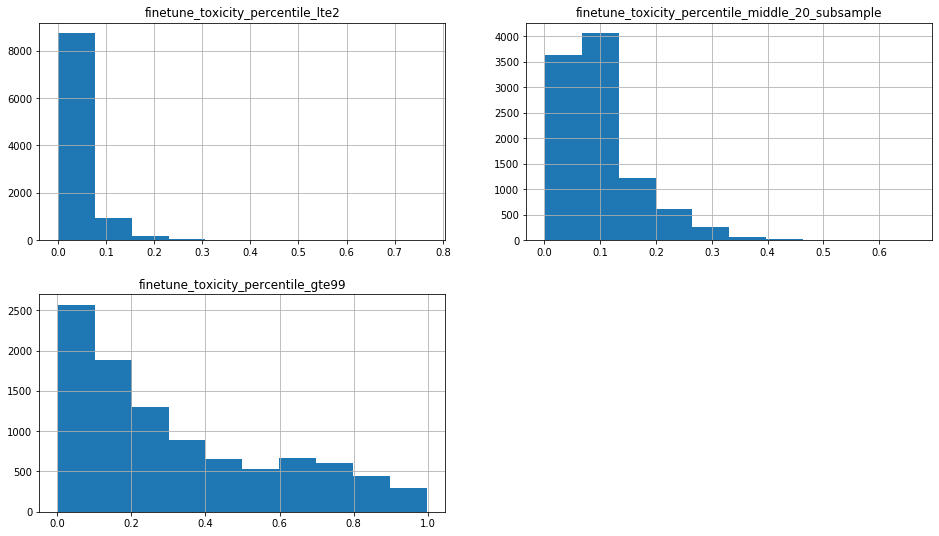

In [57]:
ncols = 2
fig, ax = plt.subplots(nrows=math.ceil(len(results) / ncols),
                       ncols=ncols,
                       sharex=False,
                       figsize=(16, 1.5 * ncols * len(results)),
                       gridspec_kw={"hspace": 0.25})

results_list = list(results.items())

i = 0
for row in ax:
    for col in row:
        try:
            name, df = results_list[i]
            df.toxicity.hist(ax=col)
            col.title.set_text(name)
        except IndexError:
            fig.delaxes(col)

        i += 1